Перед нами датасет взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней и характеристиками рекламных клиентов (те, кто разместил эти объявления). 
В таблице следующие колонки:
* ads_data.csv – данные взаимодействий с рекламными объявлениями
* date – дата
* time – время
* event – действие (просмотр/клик)
* platform – платформа
* ad_id – id объявления
* client_union_id – id рекламного кабинета
* campaign_union_id – id рекламной кампании
* ad_cost_type – тип оплаты
* ad_cost – цена
* has_video – есть ли видео
* target_audience_count – размер аудитории
* create_date – дата создания рекламного клиента

Основная задача - изучить распределение показов и кликов рекламных объявлений, выявить аномалии по показам и кликам, если имеются, и распределить рекламных клиентов по категориям в зависимости от того, как быстро они разместили рекламу с момента регистрации на площадке.

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
ad = pd.read_csv ('ad_data.csv')
ad.head(10)

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
5,2019-04-01,2019-04-01 00:16:59,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
6,2019-04-01,2019-04-01 00:21:54,view,web,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
7,2019-04-01,2019-04-01 00:29:58,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
8,2019-04-01,2019-04-01 00:32:10,view,web,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
9,2019-04-01,2019-04-01 00:33:07,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04


Посмотрим на распределение количества показов и кликов в выборке. 

In [39]:
events_number = ad.groupby(['ad_id','event'], as_index=False)\
.agg({'date':'count'})\
.rename(columns={'date': 'event_number'})
events_number.head(10)

,ad_id,event,event_number
0,2,click,1
1,2,view,101
2,3,click,3
3,3,view,184
4,1902,click,1
5,1902,view,41
6,2064,view,35
7,2132,click,1
8,2132,view,58
9,2468,view,39


По распределению видим, что показов на рекламных объявлениях выше, чем кликов (как и должно быть). Но на некоторых объявлениях (2064, 2468) только показы, это скорее всего из-за того, что на этих объявлениях еще мало показов. 

Посмотрим на среднее количество показов и кликов на объявления за весь период

In [40]:
#изменим форму данных с помощью pivot, и строки "view" и "click" станут столбцами, а их значением будет среднее от event_number
#так как не у всех объявлений были клики, на их месте образовались NaN, их нужно заменить нулями
avg_event_number = events_number\
.pivot(index='ad_id', columns='event', values='event_number')\
.fillna(0)\
.mean()\
.round()
avg_event_number

event
click    113.0
view     923.0
dtype: float64

In [41]:
print(avg_event_number[0]*100/ avg_event_number[1])

12.242686890574214


На основе среднего количества показов и кликов можно было бы сделать вывод, что на 100 показов приходится примерно 12 кликов. Но судя по таблице распределения количества показов и кликов events_number, вероятнее всего, что на 100 показов кликов приходится гораздо меньше. Возможно в данных есть какая-то аномалия

Скользящее среднее часто используется для поиска аномалий в данных. Посмотрим на одном графике значения арифметического среднего и скользящего среднего количества кликов по дням. Дни, в которых скользящее среднее равно NaN, не учитываем.

In [85]:
#создадим датафрейм с числом кликов рекламы по дням
click_by_day = ad.query('event=="click"')\
.pivot_table(index='ad_id', columns='date', values='time', aggfunc='count')
click_by_day

date,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06
ad_id,,,,,,
2,1.0,NaN,NaN,NaN,NaN,NaN
3,2.0,1.0,NaN,NaN,NaN,NaN
1902,NaN,NaN,1.0,NaN,NaN,NaN
2132,NaN,NaN,NaN,1.0,NaN,NaN
2494,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
121893,2.0,NaN,NaN,NaN,NaN,NaN
121896,NaN,NaN,NaN,1.0,NaN,NaN
121964,NaN,NaN,NaN,5.0,NaN,NaN


In [87]:
#посчитаем арифметическое среднее количества кликов по дням
mean_click_by_day = view_by_day.mean()
mean_click_by_day

date
2019-04-01      3.506024
2019-04-02      4.192308
2019-04-03      3.833333
2019-04-04      3.969136
2019-04-05    510.060773
2019-04-06    276.259259
dtype: float64

In [104]:
#посчитаем скользящее среднее количества кликов по дням
rolling_click_by_day = mean_click_by_day.rolling(2, min_periods=1).mean()
rolling_click_by_day

date
2019-04-01      3.506024
2019-04-02      3.849166
2019-04-03      4.012821
2019-04-04      3.901235
2019-04-05    257.014955
2019-04-06    393.160016
dtype: float64

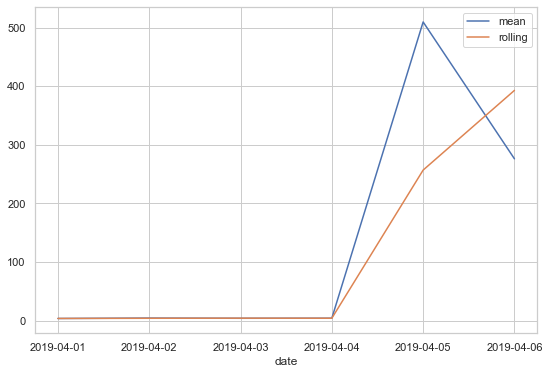

In [89]:
plt.figure(figsize=(9,6))
sns.set(style='whitegrid')
mean_click_by_day.plot(label = 'mean')
rolling_click_by_day.plot(label = 'rolling')
plt.legend()
plt.show()

По графику видим, что в некоторые дни скользящее и арифметическое среднее кликов сильно различаются, посчитаем разницу по модулю между показателями средних.

In [109]:
(mean_click_by_day- rolling_click_by_day).abs()

date
2019-04-01      0.000000
2019-04-02      0.343142
2019-04-03      0.179487
2019-04-04      0.067901
2019-04-05    253.045819
2019-04-06    116.900757
dtype: float64

In [110]:
anomaly_day = (mean_view_by_day - rolling_view_by_day).abs().idxmax()
anomaly_day

'2019-04-05'

Итак, наибольшая разница между арифметическим и скользящим средним была выявлена 2019-04-05. Возможно в этот день было выгружено объявление, которое собрало высокое количество кликов, найдем это объявление и посмотрим на него.

In [92]:
#разница в аномальный день между средним и скользящим средним
difference_value = (mean_click_by_day - rolling_click_by_day)[anomaly_day] 
difference_value

253.0458188390969

Найдем объявление с максимальным числом кликов в этот день

In [105]:
anomaly_ad = click_by_day[anomaly_day].idxmax()
anomaly_ad

112583

Если поиск аномального объявления является регулярной задачей, было бы удобно, если была бы функция под эту задачу. Создадим функцию, которая найдет проблемное объявление (с наибольшим/наименишим количеством кликов) в день, в который была замечена самая большая по модулю аномалия

In [106]:
def find_anomaly_ad (ad_find):
    mean_click_by_day = ad_find.mean() #ищем среднее 
    rolling_click_by_day = mean_click_by_day.rolling(2, min_periods=1).mean() #ищем скользящее
    
    mean_difference = (mean_click_by_day - rolling_click_by_day)
    anomaly_day = mean_difference.abs().idxmax() #ищем день, где разница среднего и скользящего максимальна
    
    difference_value = mean_difference[anomaly_day] #извлекаем из разницы средних ячейку с аномальным днем
    anomaly_ad = ad_find[anomaly_day].idxmax() #то находим рекламу с максимальными показами
    
    return anomaly_ad

In [107]:
#применим функцию к датасету
find_anomaly_ad(click_by_day)

112583

Как видим, функция дает правильный результат. Посмотрим на это объявление

In [114]:
anomaly_ad_number = events_number.query('ad_id == 112583')
anomaly_ad_number

,ad_id,event,event_number
1220,112583,click,105767
1221,112583,view,351802


In [129]:
anomaly_ad_number.event_number.iloc[0]

105767

In [131]:
print(anomaly_ad_number.event_number.iloc[0]*100/ anomaly_ad_number.event_number.iloc[1])

30.06435438115758


Действительно, наблюдается объявление c высокими показателями кликов и показов, у которого на каждые 100 показов приходится примерно 30 кликов. Такое объявление является выбросом, посмотрим на данные без этого объявления.

In [136]:
new_event_number = events_number.query('ad_id != 112583')\
.pivot(index='ad_id', columns='event', values='event_number')\
.fillna(0)\
.mean()\
.round()
new_event_number

event
click      4.0
view     559.0
dtype: float64

In [137]:
print(new_event_number[0]*100/ new_event_number[1])

0.7155635062611807


Теперь мы видим более реалистичную картину, для получения хотя бы одного клика, в среднем нужно, чтобы у рекламного объявления было более 100 показов.

Теперь подробнее исследуем рекламных клиентов. Для начала посмотрим на то, как быстро клиенты начинают запускать рекламное объявление с момента регистрации. 

Так как начинается работа с датами, посмотрим на тип данных и при необходимости передем все даты в тип datetime

In [140]:
ad.dtypes

date                      object
time                      object
event                     object
platform                  object
ad_id                      int64
client_union_id            int64
campaign_union_id          int64
ad_cost_type              object
ad_cost                  float64
has_video                  int64
target_audience_count      int64
create_date               object
dtype: object

In [141]:
ad[['date','create_date']] = ad[['date','create_date']].apply(pd.to_datetime)

In [142]:
ad[['date','create_date']].dtypes

date           datetime64[ns]
create_date    datetime64[ns]
dtype: object

Найдем среднее количество дней от даты создания рекламного клиента до первого запуска рекламного объявления клиентом.

In [145]:
#создадим функцию, которая считает разницу между датой создания кабинета и датой запуска рекламы
def find_min_diff (group): 
    diff = group.date - group.create_date
    return diff.min() #чтобы получить разницу времени для первой рекламы клиента, нужно внутри группы взять минимальное время

In [149]:
#у каждого клиента посмотрим на это минимальное время, т.е. на количество дней, которое прошло с регистрации до первого запуска
difference_days = ad.groupby('client_union_id')\
.apply(find_min_diff)
difference_days 

client_union_id
1         98 days
9        114 days
13        66 days
16       105 days
20        32 days
           ...   
122004    67 days
122013   151 days
122023   126 days
122031    96 days
122078    71 days
Length: 838, dtype: timedelta64[ns]

In [150]:
difference_days.mean()

Timedelta('124 days 09:04:43.532219570')

В среднем клиенты запускают свою первую рекламу спустя 124 дня с момента регистрации на площадке

Для более удобного восприятия разобъем рекламных клиентов по промежуткам от создания до запуска рекламного объявления.

In [160]:
воспользуемся векторизованной функцией timedelta, которая сделает список из указанных пролмежутков
bins = pd.to_timedelta([0, 30, 90, 180, 365], unit='d')
bins

TimedeltaIndex(['0 days', '30 days', '90 days', '180 days', '365 days'], dtype='timedelta64[ns]', freq=None)

In [168]:
#зададим названия нашим промежуткам
labels = ['0-30 days',
          '30-90 days',
          '90-180 days',
          '180-365 days']

In [169]:
#создадим новую колонку с промежутками с помощью метода pd.cut
ad['days_categorical'] = pd.cut(difference_days, bins=bins, labels=labels)

In [173]:
ad.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,create_date,days_categorical
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04,NaN
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04,90-180 days
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04,NaN
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04,NaN
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04,NaN


In [172]:
ad.client_union_id.nunique() #количество уникальных клиентов, которые запустили рекламные объявления на площадке

838

In [178]:
ad.days_categorical.value_counts() #распределение рекламных клиентов по промежуткам


90-180 days     396
30-90 days      263
180-365 days    168
0-30 days        11
Name: days_categorical, dtype: int64

Итак, в таблице появилась колонка, которая отражает, к какому промежутку времени от создания до запуска рекламного объявления относится каждый уникальный рекламный клиент.

Выведем на график категории по промежуткам времени от создания до запуска рекламы с количеством уникальных клиентов в них

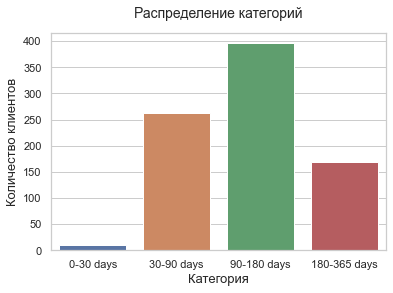

In [181]:
sns.countplot(ad.days_categorical)
plt.xlabel('Категория', fontsize=13)
plt.ylabel('Количество клиентов', fontsize=13)
plt.title('Распределение категорий', 
          fontsize=14,  
          pad='15')
plt.show()

Больше всех клиентов принадлежат категории 90-180 дней от создания до запуска рекламы